In [1]:
# Dependencies
# ----------------------------------
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [5]:
#store tables
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [6]:
#create session#create 
session = Session(engine)

In [7]:
#inspect measurement table#inspec 
precip_data = session.query(Measurements).first()
precip_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1112a9f28>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': datetime.date(2010, 1, 1),
 'meas_id': 1}

In [8]:
#dynamically creates dates from most recent date to a year before#dynami 
from datetime import datetime
most_current = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
last_date = most_current[0]
year_before = last_date.replace(year = (last_date.year - 1))
year_before = year_before.strftime("%Y-%m-%d")
year_before

'2016-08-23'

In [9]:
#query for precipitation data based on date range from most recent to a year before
twelve_months = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date > year_before)
#create data frame from sql query
twelve_months_prcp = pd.read_sql_query(twelve_months.statement, engine, index_col = 'date')

In [10]:

#inspect dataframe#inspect 
twelve_months_prcp.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


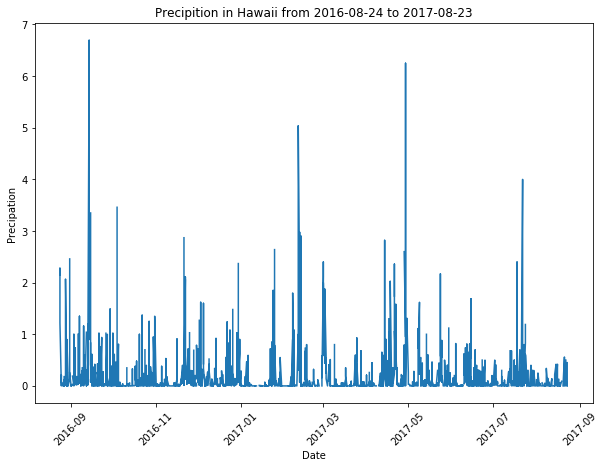

In [12]:
twelve_months_prcp.plot(figsize = (10,7), rot = 45, use_index = True, legend=False)
plt.ylabel('Precipation')
plt.xlabel('Date')
plt.title("Precipition in Hawaii from %s to %s" % (twelve_months_prcp.index.min(),twelve_months_prcp.index.max()))
plt.show()

In [13]:
#inspect station data
station_data = session.query(Stations).first()
station_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x111423550>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'station': 'USC00519397'}

In [14]:

#get station count, has been checked with measurement station count#get sta 
from sqlalchemy import func
num_stations = session.query(Stations.station).group_by(Stations.station).count()

In [15]:
num_stations


9

In [16]:

#query tables to get count of daily report, all temp data is complete for each record, so the count#query t 
#reflects a count of a station giving temp data, prcp data may or may not have been reported on that date
activity = session.query(Stations.station, Stations.name, Measurements.station, func.count(Measurements.tobs)).filter(Stations.station == Measurements.station).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).all()

In [17]:
activity

[('USC00519281', 'WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 'USC00517948', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [18]:
#most active station
max_activity = activity[0][0:2]
max_activity

('USC00519281', 'WAIHEE 837.5, HI US')

In [19]:

# the number of reports from the most active station# the nu 
temps_maxact = session.query(Measurements.station, Measurements.tobs).filter(Measurements.station == max_activity[0], Measurements.date > year_before).all()

In [20]:
len(temps_maxact)


351

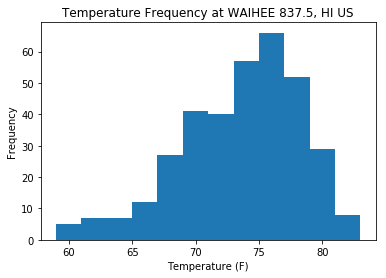

In [21]:
#list created from temperature data query from the most active station
temps = [x[1] for x in temps_maxact]
plt.hist(temps, bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Frequency at %s" % (max_activity[1]))
plt.show()


In [22]:
def calc_temps(start_date, end_date):
    #create dates 1 year prior
    dates = [start_date, end_date]
    new_dates = []
    for date in dates:
        date_list = date.split("-")
        date_list[0] = str(int(date_list[0]) - 1)
        new_date = "-".join(date_list)
        new_dates.append(new_date)
    print(new_dates) 
    
    #query database for temps from those dates
    temp_values = session.query(Measurements.tobs).filter(Measurements.date >= new_dates[0], Measurements.date <= new_dates[1]).all()
    temp_values_list = [x for (x,) in temp_values]
    avg_temp = np.mean(temp_values_list)
    max_temp = max(temp_values_list)
    min_temp = min(temp_values_list)
    
    # create bar graph
    plt.figure(figsize=(2,5))
    plt.title("Trip Average Temp")
    plt.ylabel("Temperature (F)")
    plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "")
    plt.show()

['2017-08-01', '2017-08-14']


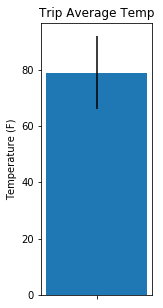

In [23]:
calc_temps('2018-08-01', '2018-08-14')